In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
from scipy.stats import t
from sklearn.model_selection import train_test_split

In [54]:
data = pd.read_csv("movies.csv")
#Did the director write the movie on own
data["self"] = np.where(
    data["director_id"] == data["writer_id"],
    1, 0
)

data = data.drop(["movie_id", "link", "director_id", "director_name",
          "writer_id", "writer_name", "storyline","user_id","cast_name", "user_name",
          "review_title", "review_content"], axis = 1)
data

,rank,title,year,imbd_votes,imbd_rating,certificate,duration,genre,cast_id,review_id,self
0,1,The Shawshank Redemption,1994,"2,711,075",9.3,R,2h 22m,Drama,"nm0000209,nm0000151,nm0348409,nm0006669,nm0000...","rw2284594,rw6606154,rw1221355,rw1822343,rw1288...",0
1,2,The Godfather,1972,"1,882,829",9.2,R,2h 55m,"Crime,Drama","nm0000008,nm0000199,nm0001001,nm0144710,nm0000...","rw3038370,rw4756923,rw4059579,rw6568526,rw1897...",0
2,3,The Dark Knight,2008,"2,684,051",9.0,PG-13,2h 32m,"Action,Crime,Drama","nm0000288,nm0005132,nm0001173,nm0000323,nm0350...","rw5478826,rw1914442,rw6606026,rw1917099,rw5170...",0
3,4,The Godfather Part II,1974,"1,285,350",9.0,R,3h 22m,"Crime,Drama","nm0000199,nm0000380,nm0000473,nm0000134,nm0001...","rw0135607,rw0135487,rw5049900,rw0135526,rw0135...",0
4,5,12 Angry Men,1957,"800,954",9.0,Approved,1h 36m,"Crime,Drama","nm0000842,nm0275835,nm0002011,nm0550855,nm0001...","rw0060044,rw0060025,rw0060034,rw2262425,rw5448...",0
...,...,...,...,...,...,...,...,...,...,...,...
245,246,Dersu Uzala,1975,"31,167",8.2,G,2h 22m,"Adventure,Biography,Drama","nm0813272,nm0613364,nm0125730,nm1276196,nm6210...","rw1024676,rw0134934,rw1122059,rw2168879,rw2373...",0
246,247,The Help,2011,"466,011",8.1,PG-13,2h 26m,Drama,"nm1297015,nm0205626,nm0397171,nm0818055,nm1567...","rw2473566,rw2472337,rw2472299,rw2697863,rw2488...",0
247,248,Aladdin,1992,"429,219",8.0,G,1h 30m,"Animation,Adventure,Comedy","nm0918334,nm0000245,nm0488306,nm0293455,nm0919...","rw0302749,rw0950861,rw1571053,rw2534639,rw0302...",0
248,249,Gandhi,1982,"234,688",8.0,PG,3h 11m,"Biography,Drama,History","nm0001426,nm0368990,nm0786022,nm0000298,nm0002...","rw0194126,rw1179566,rw1106866,rw0194132,rw0194...",0


In [55]:
#number of casts, reviews
data["cast_n"] = data["cast_id"].apply(lambda x: len(x.split(",")))
data["review_n"] = data["review_id"].apply(lambda x: len(x.split(",")))
data = data.drop(["cast_id", "review_id"], axis = 1)

In [56]:
#"xh" -> "xh 0m", "xm" -> "0h xm"
def time(x):
    if len(x) == 2:
        x =  x + " 0m"
    elif len(x) == 3:
        x = "0h " + x
    else:
        x = x
    return(x)

In [57]:
data["duration"] = data["duration"].apply(time)

In [58]:
#duration into minute
dur = []
for x in data["duration"]:
    dur.append(int(x.split(" ")[0][:-1]) * 60 + int(x.split(" ")[1][:-1]))
data["duration"] = dur

In [59]:
#Genre: Choose first one
data["genre"] = data["genre"].apply(lambda x: x.split(",")[0])

In [60]:
data["certificate"].unique()
#R, 18+, X, TV-MA => for legal adults

array(['R', 'PG-13', 'Approved', 'PG', '18+', 'Not Rated', 'G', 'Passed',
       nan, 'TV-PG', 'Unrated', 'X', '13+', 'TV-MA', 'GP'], dtype=object)

In [61]:
data[(data["certificate"].isna()) | (data["certificate"] == "Unrated")]
#The Boat is Rated R
#Requiem for a Dream is Rated R


,rank,title,year,imbd_votes,imbd_rating,certificate,duration,genre,self,cast_n,review_n
76,77,The Boat,1981,"253,534",8.4,NaN,149,Drama,0,42,25
84,85,Requiem for a Dream,2000,"852,453",8.3,Unrated,102,Drama,0,79,25


In [62]:
data["certificate"][(data["title"] == "The Boat") | (data["title"] == "Requiem for a Dream")] = "R"

<ipython-input-62-abe1f19645bd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["certificate"][(data["title"] == "The Boat") | (data["title"] == "Requiem for a Dream")] = "R"


In [63]:
#R, 18+, X, TV-MA => for legal adults
#1 == for adults
def age(x):
    if x == "R" or x == "18+" or x == "X" or x == "TV-MA":
        return(1)
    else:
        return(0)
    
data["certificate"] = data["certificate"].apply(age)

In [64]:
data['imbd_votes'] = data['imbd_votes'].str.replace(',', '').astype(float)

In [65]:
#movies after 2000
df=data.copy()
df['recent'] = df['year']>=2000

**2. Descriptive Analytics Research Question Set**

1. Goal: You should pick three or more variables and explore the relationship
between these variables in the dataset.
- For instance, you could ask “What is the relationship between x and y in
this dataset? Furthermore, how does this relationship between x and y
change for different values of z?”
2. State your research question you will answer with your analysis. Remember,
descriptive analytics only involves describing relationships in the dataset that you
have, so your research question should be just about the dataset.
3. Use at least one visualization to answer this question. You should have at least
one visualization that incorporates 3 or more variables in the same plot.
4. Use at least one set of summary statistics to help answer this question as well.
5. Describe what you see in your visualization and summary statistics, what they tell
you, and how they help answer your research question.

**research question**

What is the relationship between the duration of movie and imdb votes? Furthermore, how do the duration and imbd votes change based on whether a movie was released recently or not?

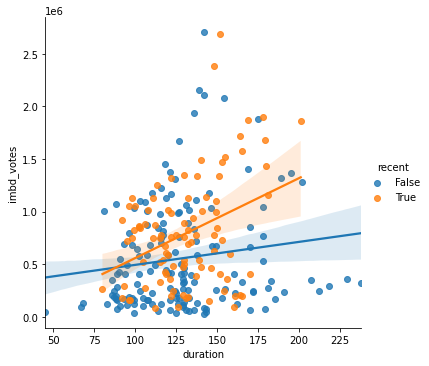

In [66]:
sns.lmplot(x='duration', y='imbd_votes', hue='recent', data=df)
plt.show()

In [68]:
sum_stat=df.groupby('recent')[['duration', 'imbd_votes']].mean()
sum_stat

,duration,imbd_votes
recent,,
False,127.941558,555848.12987
True,131.041667,795252.53125


**research question:** 

What is the relationship between the duration of movie and imdb votes? Furthermore, how do the duration and imbd votes change based on whether a movie was released recently or not?


From scatter plot above is moderately strong, showing positive relationship between duration and imbd_votes for both recent and older movies. There are some outliers with relatively long duration and very high imbd votes. The center of the spread is around 100-125 with concentration around 0 and 1 million votes. 

From this summary statistic, we can see that the mean duration is longer for recent movies (after 2000) and imdb votes is also higher for recent movies. 


**3. Inference Research Question Set**
1. Goal: You should pick two variables (at least one categorical) and explore the
relationship between these variables in a population.
- For instance, you could ask “Is there an association between x and y in
my population?”
- Choose one of the following types of inference parameters: difference in two population proportions, difference of two population means, or challenge yourself with ANOVA.
2. State your research question that you will answer with your analysis. Remember,
inferential statistics involves answering research questions about populations
given a random sample from that population. Your research question should
reference the population from which your data were collected.
3. Complete at least one hypothesis test to answer this research question, including
- Stating your hypotheses,
- Checking the conditions for this test,
- Calculating a p-value (or confidence interval) for this test by hand, and
4. Using your results to state a conclusion.
5. Finally, discuss how your conclusion answers your research question.

In [69]:
#Certificate(Category - 0, 1) vs Duration
#Is there an association between whether the movie is only for adults and duration of the movie?
adult = df[df["certificate"] == 1]
adultx = df[df["certificate"] == 0]

- Set hypothesis to check if there is a difference in duration of movies between movie for adults and movie for everyone.
- $H_0$: $Mu_1$ - $Mu_2$ = 0
- $H_a$: $Mu_1$ - $Mu_2$ != 0

**Condition check**
- Independency: Two samples are independent to each other, and each observation is independent as well.
- Normality: As the sample size is over 100, the sample size is large enough. We can assume that the normality assumption may be met due to central limit theorem.
- Random Sampling: Since the sample is collected by subseting top 250 movies depending on the IMDB rating, it is hard to tell that the data itself is collected random. So, we conducted random sample simulation through sampling with replacement from the data.

In [70]:
mu_diff = []
for i in range(10000):
    sample_adult = adult.sample(len(adult), replace = True, random_state = i)
    sample_adultx = adultx.sample(len(adultx), replace = True, random_state = i)
    
    Mu_1 = sample_adult["duration"].mean()
    Mu_2 = sample_adultx["duration"].mean()
    mu_diff.append(Mu_1 - Mu_2)

In [71]:
mu = np.array(mu_diff).mean()
std_1 = adult["duration"].std()
std_2 = adultx["duration"].std()
pooled = np.sqrt(((len(adult) - 1) * (std_1 ** 2)) + ((len(adultx) - 1) * (std_2 ** 2))) / np.sqrt(len(adult) + len(adultx) - 2)
test_statistics = mu / (pooled * np.sqrt((1/len(adult)) + (1/len(adultx))))
p_val = (1 - (t.cdf(test_statistics, df = len(df) - 2))) * 2
p_val

0.050402055592104755

Since the p-value is slightly over the significance level 0.05, there is no sufficient evidence to tell that there is a difference between duration of movies depending on whehter they are for adults or everyone. Result of this hypothesis test answers our research question with the answer "No".

**4. Linear Regression Research Question Set**
1. Goal: You should pick a numeric response variable and at least four explanatory variables that you suspect might affect your response variable. Explore whether there is a linear relationship between the explanatory variables and the response variable, in the dataset and in the population.
- For instance, you could ask two questions like: “Is there a linear relationship between y and x1, x2, x3, and x4 in the sample? What about in the relevant population?”
2. State your research question(s) you’d like to answer with your analysis.
3. Use at least one linear regression model to answer this question. Include the following:
- Show the summary output for your linear regression.
- Write out the linear regression equation for your model. Use appropriate notation.
- Check the linear regression conditions. If they are not met, try transforming one of the variables (maybe with a natural log) and see if that helps meet the conditions. If you have multicollinear explanatory variables, try dropping one. (If dropping a multicollinear variable brings you below the four required explanatory variables, this is ok. Be sure you show the progression of your analysis, including your model with at least four variables.).
- Discuss what percent of variability in your response variable is explained by this model in the dataset. Is this high? Is this low?
- Make at least one prediction with your model.
- Which slopes in your model do we have sufficient evidence to suggest are non-zero in the population model? Explain your answer.
4. Finally, discuss how your linear regression analysis helps answer your research question.


**research question**

Is there a linear relationship between the duration of move and imbd votes, when it was released, cast number? What about in the relevant population?

In [72]:
df.head()

,rank,title,year,imbd_votes,imbd_rating,certificate,duration,genre,self,cast_n,review_n,recent
0,1,The Shawshank Redemption,1994,2711075.0,9.3,1,142,Drama,0,73,25,False
1,2,The Godfather,1972,1882829.0,9.2,1,175,Crime,0,84,25,False
2,3,The Dark Knight,2008,2684051.0,9.0,0,152,Action,0,243,25,True
3,4,The Godfather Part II,1974,1285350.0,9.0,1,202,Crime,0,110,25,False
4,5,12 Angry Men,1957,800954.0,9.0,0,96,Crime,0,18,25,False


**i.** Show the summary output for your linear regression.

In [73]:
results = smf.ols('duration ~ imbd_votes+year+cast_n+certificate', data=df).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               duration   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     11.60
Date:                Wed, 03 May 2023   Prob (F-statistic):           1.22e-08
Time:                        16:02:40   Log-Likelihood:                -1184.4
No. Observations:                 250   AIC:                             2379.
Df Residuals:                     245   BIC:                             2396.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      86.5171    159.571      0.542      0.588    -227.789     400.823
imbd_votes   3.851e-06   3.99e-06      0.965      0.335   -4.01e-06    1.17e-05
year            0.0117      0.081      0.145      0.885      -0.148       0.171
cast_n          0.1924      0.034      5.632      0.000       0.125       0.260
certificate     5.8225      3.938      1.479      0.141      -1.933      13.578
==============================================================================
Omnibus:                       35.257   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.029
Skew:                           0.927   Prob(JB):                     6.13e-11
Kurtosis:                       4.038   Cond. No.                     7.52e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.52e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**ii.** Write out the linear regression equation for your model. Use appropriate notation.

$\hat{y}$ = 86.5171 + 3.851e-06imbd_votes + 0.0117year + 0.1924cast_n + 5.8225certificate

**iii.** Check the linear regression conditions. If they are not met, try
transforming one of the variables (maybe with a natural log) and see if
that helps meet the conditions. If you have multicollinear explanatory
variables, try dropping one. (If dropping a multicollinear variable brings you below the four required explanatory variables, this is ok. Be sure you show the progression of your analysis, including your model with at least four variables.).

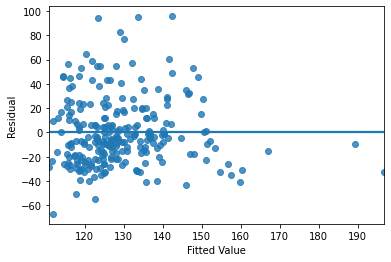

In [74]:
#Condition 1: Linearity Condition

sns.regplot(x=results.fittedvalues, y=results.resid, ci=None)
plt.ylabel('Residual')
plt.xlabel('Fitted Value')
plt.show()

The distribution of points in the plot are not evenly distributed above and below the line. We can say the linearity condition is not met. 

Condition 2: Constant Variability of Residuals

The y-axis spread of points in the plot slightly changes as we move from left to right. This condition is also met. 

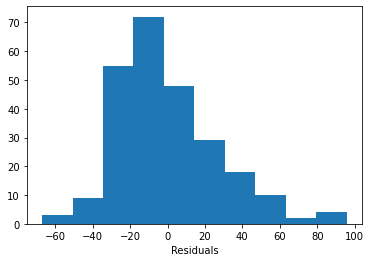

In [75]:
#Condition 3: Normality of Residuals (with Mean of 0) Condition
plt.hist(results.resid)
plt.xlabel('Residuals')
plt.show()

The histogram is slightly right-skewed, however approximately normally distributed. The assumption that the residuals are normally distributed is met.

Condition 4: Independence of Residuals Condition

Data is randomly sampled and the sample size n=250<10% of all imdb movies. 

Thus, the condition for independence of residuals may not be violated.

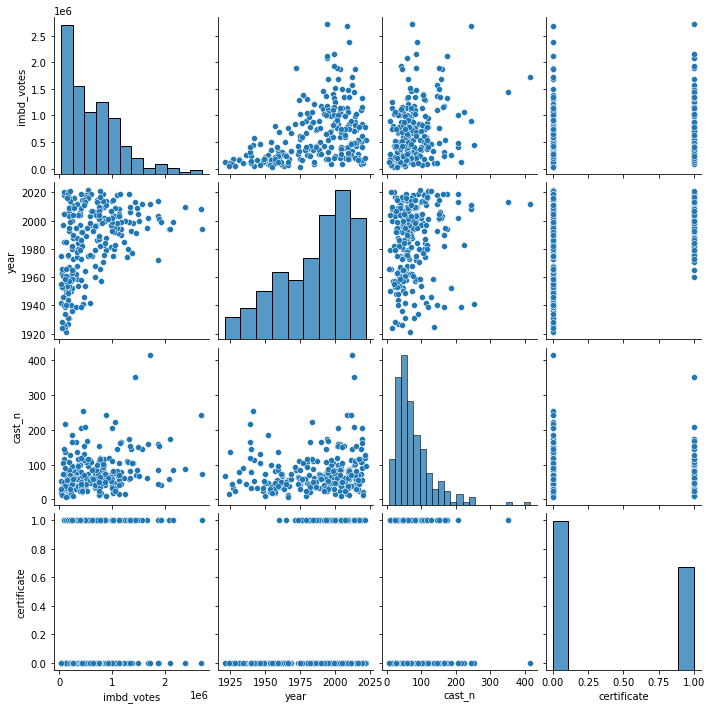

In [76]:
#Condition 5: No Multicollinearity Condition
sns.pairplot(df[['imbd_votes','year','cast_n','certificate']])
plt.show()

In [77]:
df[['imbd_votes','year','cast_n','certificate']].corr()

,imbd_votes,year,cast_n,certificate
imbd_votes,1.000000,0.427422,0.327963,0.302194
year,0.427422,1.000000,0.149116,0.365248
cast_n,0.327963,0.149116,1.000000,0.013909
certificate,0.302194,0.365248,0.013909,1.000000


We can see that there is a moderately high linear relationship between the explanatory variables but not as high to violate the multicollinearity condition.

Since condition 1, 2, and 3 are not met, we will try transforming some variables. 



In [78]:
df['logduration'] = np.log(df['duration'])

In [79]:
newresult = smf.ols('logduration ~ imbd_votes+year+cast_n+certificate', data=df).fit()

newresult.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            logduration   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     13.05
Date:                Wed, 03 May 2023   Prob (F-statistic):           1.19e-09
Time:                        16:03:16   Log-Likelihood:                 33.773
No. Observations:                 250   AIC:                            -57.55
Df Residuals:                     245   BIC:                            -39.94
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       3.6287      1.221      2.972      0.003       1.224       6.034
imbd_votes   2.829e-08   3.05e-08      0.927      0.355   -3.18e-08    8.84e-08
year            0.0005      0.001      0.856      0.393      -0.001       0.002
cast_n          0.0015      0.000      5.676      0.000       0.001       0.002
certificate     0.0521      0.030      1.729      0.085      -0.007       0.111
==============================================================================
Omnibus:                        6.309   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.043   Jarque-Bera (JB):                8.230
Skew:                           0.173   Prob(JB):                       0.0163
Kurtosis:                       3.819   Cond. No.                     7.52e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.52e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

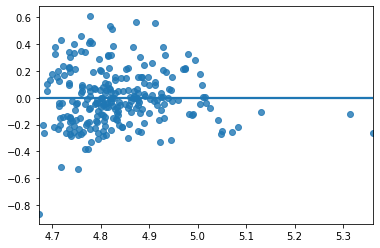

In [80]:
sns.regplot(x=newresult.fittedvalues, y=newresult.resid, ci=None)

plt.show()

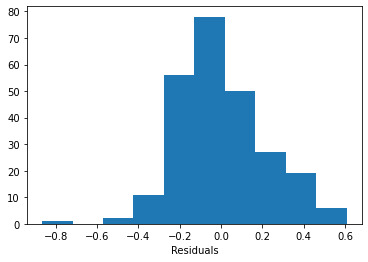

In [81]:
# results = smf.ols('imbd_rating ~ rank+year+imbd_votes+certificate+genre+duration+self+cast_n+review_n+recent', data=df).fit()
# results.summary()
plt.hist(newresult.resid)
plt.xlabel('Residuals')
plt.show()

After the log-transformation, the scatter plot is more evenly distributed below and above the line. The histogram is also not right-skwed, and more bell-shaped than before. Therefore, we would like to say that the log-transformation was helpful in improving our assumptions.

**iv.** Discuss what percent of variability in your response variable is explained by this model in the dataset. Is this high? Is this low?

R-squared of 0.159 indicates that 15.9% of the variability in the response variable is explained by the independent variable. R-squared of 0.159 is low.

**v.** Make at least one prediction with your model.

We are predicting duration of a movie with 75 cast number, with imbd votes of 600000 released in 2020 with certificate of 1 (R-rated)

In [82]:
predict=newresult.predict(exog=dict(cast_n= 75, imbd_votes=600000, year=2020, certificate=1))
np.exp(predict)

0    131.768089
dtype: float64

our predicted duration is 131.768089 minutes.

**vi.** Which slopes in your model do we have sufficient evidence to suggest are non-zero in the population model? Explain your answer.

In [83]:
results.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,86.5171,159.571,0.542,0.588,-227.789,400.823
imbd_votes,3.851e-06,3.99e-06,0.965,0.335,-4.01e-06,1.17e-05
year,0.0117,0.081,0.145,0.885,-0.148,0.171
cast_n,0.1924,0.034,5.632,0.000,0.125,0.260
certificate,5.8225,3.938,1.479,0.141,-1.933,13.578


In [84]:
results.pvalues[['cast_n','imbd_votes', 'year', 'certificate']]

cast_n         4.871182e-08
imbd_votes     3.353226e-01
year           8.851152e-01
certificate    1.405021e-01
dtype: float64

cast number, imbd_votes, year, and duration is likely to be non-zero in the population as they have p-value less than 0.05. This indicates that the coefficient of slope is statistically significant. 

We also conducted f-test to see if there is a linear relationship between slopes.

H0: $\beta_1 = \beta_2 = \beta_3 = \beta_4 = 0$ (No linear relationship)

H1: at least one $\beta_i != 0$ (for i = 1,2,3,4) (There is a linear relationship)

In [85]:
from scipy.stats import f
test_stat = 13.05
# df1 = p = 4
# df2 = n-p-1 = 245

pvalue = 1-f.cdf(test_stat, dfn = 4, dfd = 245)
print('pvalue:', pvalue)

pvalue: 1.1935877841651177e-09


Because the p-value is very small, we reject the null hypothesis and suggest that there is sufficient evidence to suggest that at least one of the four population slopes in the model predicting imbd_rate with genre, imbd_votes, year, and duration is non-zero. 

**research question:** Is there a linear relationship between imbd_rating and imbd votes, when it was released, genre, and duration? What about in the relevant population?

**d.** Finally, discuss how your linear regression analysis helps answer your research question.


After conducting f-test, the p value is very small, and we would like to conclude that there is a linear relationship between imbd_rating and imbd_votes, year, genre and duration. Even though the linear regression conditions are slightly not met, from the summary table, we can see that except for genre, small p-values prove the linear relationship. In relevant population, which would be all movies released in IMDB, since the sample is from the relevant population, we can say that the sample reflects the population. Therefore, the linear relationship also exists in the relevant population. 


5. Logistic Regression Research Question Set [20 points]

a. Goal: You should pick (or make) a categorical response variable with two levels and at least four explanatory variables that you suspect might affect your response variable. Explore whether there is a linear relationship between the explanatory variables and the log-odds of the success level of the response variable, in the dataset and in the population.

i. For instance, you could ask questions like: “Is there a linear relationship between the log-odds of the success level of y and x1, x2, x3, and x4 in the sample? What about in the relevant population? What explanatory variables should we include in the model to build a parsimonious model?”

ii. Hint: You can create a 0/1 categorical variable from a categorical variable using the map function or from a numeric variable by modifying the code: df[‘new_cat_var’] = 1 * (df[‘num_var’] >= some_number)
b. State your research question(s) you’d like to answer with your analysis.

c. Use at least one logistic regression model to answer this question. Include the following:

    i. Split your dataset into a training dataset and testing dataset.
    ii. Starting with four (or more) explanatory variables and using your training dataset, perform a backwards elimination algorithm (using AIC or BIC) to help you find a parsimonious logistic regression model. We will discuss this during lecture in mid-April.
    iii. Then fit your final parsimonious logistic regression model with just your training dataset.
    iv. Show the summary output for your final logistic regression model.
    v. Write out the logistic regression equation for your final model.
    vi. Which slopes in your final model do we have sufficient evidence to suggest are non-zero in the population model? Explain your answer.
    vii. Use your logistic regression model to calculate the ROC and AUC of your test dataset.
    viii. Use your ROC to pick a good predictive probability threshold. Explain why this is a good predictive probability threshold, given your research goals.
    ix. Use this predictive probability threshold to classify your test data. What is the false positive rate and the true positive rate of your classification of the test data? 
    
d. Finally, discuss how your logistic regression analysis helps answer your research
question

In [33]:
df.head()

,rank,title,year,imbd_votes,imbd_rating,certificate,duration,genre,self,cast_n,review_n,recent,logduration
0,1,The Shawshank Redemption,1994,2711075.0,9.3,1,142,Drama,0,73,25,False,4.955827
1,2,The Godfather,1972,1882829.0,9.2,1,175,Crime,0,84,25,False,5.164786
2,3,The Dark Knight,2008,2684051.0,9.0,0,152,Action,0,243,25,True,5.023881
3,4,The Godfather Part II,1974,1285350.0,9.0,1,202,Crime,0,110,25,False,5.308268
4,5,12 Angry Men,1957,800954.0,9.0,0,96,Crime,0,18,25,False,4.564348


**research question:**
“Is there a linear relationship between the log-odds of the success level of 'recent' and imbd_rating, imbd_votes, duration, and certificate? What about in the relevant population? What explanatory variables should we include in the model to build a parsimonious model?

In [86]:
from sklearn.model_selection import train_test_split

df['y'] = df['recent'].astype(str).map({'False':0, 'True':1})

df_train, df_test = train_test_split(df, test_size=0.20, random_state=123)

df_train.shape[0]/df.shape[0]
df.head()

,rank,title,year,imbd_votes,imbd_rating,certificate,duration,genre,self,cast_n,review_n,recent,logduration,y
0,1,The Shawshank Redemption,1994,2711075.0,9.3,1,142,Drama,0,73,25,False,4.955827,0
1,2,The Godfather,1972,1882829.0,9.2,1,175,Crime,0,84,25,False,5.164786,0
2,3,The Dark Knight,2008,2684051.0,9.0,0,152,Action,0,243,25,True,5.023881,1
3,4,The Godfather Part II,1974,1285350.0,9.0,1,202,Crime,0,110,25,False,5.308268,0
4,5,12 Angry Men,1957,800954.0,9.0,0,96,Crime,0,18,25,False,4.564348,0


In [87]:
current_mod = smf.logit('y ~imbd_rating+imbd_votes+duration+certificate', data=df_train).fit()
print(current_mod.bic)
#goal: small BIC

Optimization terminated successfully.
         Current function value: 0.607184
         Iterations 5
269.3652849276668


In [88]:
#delete rating
test_mod = smf.logit('y ~imbd_votes+duration+certificate', data=df_train).fit()
print(test_mod.bic)

Optimization terminated successfully.
         Current function value: 0.633683
         Iterations 5
274.66645697944665


In [89]:
#delete imbd_votes
test_mod = smf.logit('y ~imbd_rating+duration+certificate', data=df_train).fit()
print(test_mod.bic)

Optimization terminated successfully.
         Current function value: 0.651092
         Iterations 5
281.62993181674875


In [90]:
#delete duration
test_mod = smf.logit('y ~imbd_rating+imbd_votes+certificate', data=df_train).fit()
print(test_mod.bic)

Optimization terminated successfully.
         Current function value: 0.611227
         Iterations 5
265.683874900995


In [91]:
#delete certificate
test_mod = smf.logit('y ~imbd_rating+imbd_votes+duration', data=df_train).fit()
print(test_mod.bic)

Optimization terminated successfully.
         Current function value: 0.607219
         Iterations 5
264.0809716502652


Removing certificate, I have the smallest BIC.

In [92]:
current_mod = smf.logit('y ~imbd_rating+imbd_votes+duration', data=df_train).fit()
print(current_mod.bic)
df[['imbd_rating', 'imbd_votes']].corr()

Optimization terminated successfully.
         Current function value: 0.607219
         Iterations 5
264.0809716502652


,imbd_rating,imbd_votes
imbd_rating,1.000000,0.603062
imbd_votes,0.603062,1.000000


In [93]:
#delete rating
test_mod = smf.logit('y ~imbd_votes+duration', data=df_train).fit()
print(test_mod.bic)

Optimization terminated successfully.
         Current function value: 0.634002
         Iterations 5
269.49569889953983


In [94]:
#delete imbd_votes
test_mod = smf.logit('y ~imbd_rating+duration', data=df_train).fit()
print(test_mod.bic)

Optimization terminated successfully.
         Current function value: 0.654519
         Iterations 5
277.7027465378036


In [95]:
#delete duration
test_mod = smf.logit('y ~imbd_votes+imbd_rating', data=df_train).fit()
print(test_mod.bic)

Optimization terminated successfully.
         Current function value: 0.611314
         Iterations 5
260.4207462078077


In [96]:
current_mod = smf.logit('y ~imbd_votes+imbd_rating', data=df_train).fit()
print(current_mod.bic)

Optimization terminated successfully.
         Current function value: 0.611314
         Iterations 5
260.4207462078077


In [97]:
#delete imbd_votes
test_mod = smf.logit('y ~imbd_rating', data=df_train).fit()
print(test_mod.bic)

Optimization terminated successfully.
         Current function value: 0.658648
         Iterations 4
274.0559088316164


We had the smallest BIC when our test_mod was 'y ~imbd_votes+imbd_rating'

In [98]:
final_mod = smf.logit('y ~ imbd_votes+imbd_rating', data=df_train).fit()
final_mod.summary()

Optimization terminated successfully.
         Current function value: 0.611314
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  200
Model:                          Logit   Df Residuals:                      197
Method:                           MLE   Df Model:                            2
Date:                Wed, 03 May 2023   Pseudo R-squ.:                 0.07230
Time:                        16:05:10   Log-Likelihood:                -122.26
converged:                       True   LL-Null:                       -131.79
Covariance Type:            nonrobust   LLR p-value:                 7.277e-05
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      20.5510      7.354      2.795      0.005       6.138      34.964
imbd_votes   1.607e-06   3.92e-07      4.103      0.000    8.39e-07    2.37e-06
imbd_rating    -2.6751      0.909     -2.943      0.003      -4.456      -0.894
===============================================================================
"""

v. Write out the logistic regression equation for your final model.

y^ = 20.5510 + 1.607e-06imbd_votes -2.6751imbd_rating

vi. Which slopes in your final model do we have sufficient evidence to
suggest are non-zero in the population model? Explain your answer.

- Variables imbd_votes and imbd_rating have non-zero slopes according to the summary table. They have significantly low p-values, and their confidnce interval do not contain 0.

vii. Use your logistic regression model to calculate the ROC and AUC of your
test dataset.

In [100]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

In [102]:
pred_probabilities = final_mod.predict(exog = dict(df_test))
df_test['predictive_prob'] = pred_probabilities
df_test['yhat'] = 1 * (df_test['predictive_prob']>0.5)
df_test.head()

<ipython-input-102-47e8fa2f29a4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictive_prob'] = pred_probabilities
<ipython-input-102-47e8fa2f29a4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['yhat'] = 1 * (df_test['predictive_prob']>0.5)


,rank,title,year,imbd_votes,imbd_rating,certificate,duration,genre,self,cast_n,review_n,recent,logduration,y,predictive_prob,yhat
127,128,The Kid,1921,128080.0,8.3,0,68,Comedy,1,68,25,False,4.219508,0,0.190540,0
187,188,In the Name of the Father,1993,178055.0,8.1,1,133,Biography,0,106,24,False,4.890349,0,0.303399,0
24,25,Interstellar,2014,1870060.0,8.6,0,169,Adventure,0,44,25,True,5.129899,1,0.634296,1
206,207,Tokyo Story,1953,63208.0,8.2,0,136,Drama,0,30,25,False,4.912655,0,0.216996,0
235,236,Amores Perros,2000,243622.0,8.1,1,154,Drama,0,46,25,True,5.036953,1,0.326121,0


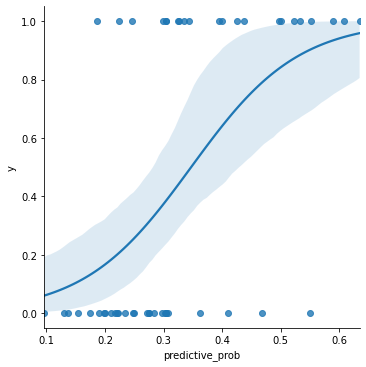

In [106]:
sns.lmplot(x='predictive_prob', y='y', data=df_test, logistic=True)

plt.show()

In [107]:
fprs, tprs, thresholds = roc_curve(y_true=df_test['y'], y_score=df_test['predictive_prob'])

auc = roc_auc_score(y_true=df_test['y'], y_score=df_test['predictive_prob'])

print(auc)

0.8311688311688311


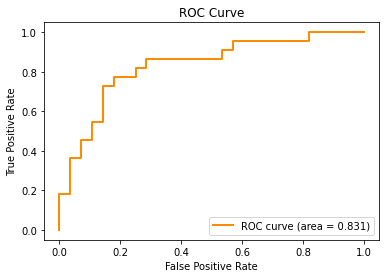

In [108]:
def plot_roc(fpr, tpr, auc, lw=2):
    plt.plot(fpr, tpr, color='darkorange', lw=lw,
            label='ROC curve (area = '+str(round(auc,3))+')')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='' )
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
plot_roc(fprs, tprs, auc)

“Is there a linear relationship between the log-odds of the success level of 'recent' and imbd_rating, imbd_votes, duration, and certificate? What about in the relevant population? What explanatory variables should we include in the model to build a parsimonious model?

viii. Use your ROC to pick a good predictive probability threshold. Explain why this is a good predictive probability threshold, given your research goals.


According to ROC plot,we chose 0.3 as our threshold because we want to balance the true positive rate and false positive rate. Our research question to determine the 'recent'

In [109]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score


df_test['yhat1'] = 1 * (df_test['predictive_prob']>0.5)
df_test.head()

<ipython-input-109-19c8d66fa1ea>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['yhat1'] = 1 * (df_test['predictive_prob']>0.5)


,rank,title,year,imbd_votes,imbd_rating,certificate,duration,genre,self,cast_n,review_n,recent,logduration,y,predictive_prob,yhat,yhat1
127,128,The Kid,1921,128080.0,8.3,0,68,Comedy,1,68,25,False,4.219508,0,0.190540,0,0
187,188,In the Name of the Father,1993,178055.0,8.1,1,133,Biography,0,106,24,False,4.890349,0,0.303399,0,0
24,25,Interstellar,2014,1870060.0,8.6,0,169,Adventure,0,44,25,True,5.129899,1,0.634296,1,1
206,207,Tokyo Story,1953,63208.0,8.2,0,136,Drama,0,30,25,False,4.912655,0,0.216996,0,0
235,236,Amores Perros,2000,243622.0,8.1,1,154,Drama,0,46,25,True,5.036953,1,0.326121,0,0


In [110]:
confusion_matrix(y_true = df_test['y'], y_pred=df_test['yhat1'])

array([[27,  1],
       [16,  6]], dtype=int64)

In [111]:
tn, fp, fn, tp = confusion_matrix(y_true=df_test['y'],
y_pred=df_test['yhat1']).ravel()
(tn, fp, fn, tp)

(27, 1, 16, 6)

In [112]:
sensitivity=tp/(tp+fn)
print('sensitivity:', sensitivity)

sensitivity: 0.2727272727272727


In [113]:
specificity=tn/(tn+fp)
print('specificity:', specificity)

specificity: 0.9642857142857143


In [114]:
false_positive_rate=fp/(tn+fp)
print('false positive rate:', false_positive_rate)

false positive rate: 0.03571428571428571


ix. Use this predictive probability threshold to classify your test data. What is the false positive rate and the true positive rate of your classification of the test data?

“Is there a linear relationship between the log-odds of the success level of 'recent' and imbd_rating, imbd_votes, duration, and certificate? What about in the relevant population? What explanatory variables should we include in the model to build a parsimonious model?

**6. Conclusion**
- Analyzing the dataset, we had few different research questions. For descriptive analytics, we wondered if there is a relationship between the duration of movies and the number of votes. In addition, we wondered if the duration and the number of votes change based on whether movies are released recently or not. Through analyzing visualization and summary statistics, there was a positive relationship between duration and the number of votes, and mean duration was longer for recently created movies. For interfence research, we wondered if there is a difference between duration by whether movie is only for adult or not. Through simulation study an hypothesis testing, we found out that there is no significant evidence to conclude there is a difference in durations. For linear regression, we tried to find out whether ther is a linear relationship between duration and other variables. After creating linear model with four suspect variables which are the number of votes, year, the number of casts, and certificate. Analyzing the model summary table and F-statistics, even though assumptions are not perfectly met, we could conclude that at least one of four variables have linear relationship with the duration of movies. Therefore, the linear relationship also exists in the relevant population. Lastly, for the logistic regression, our research question was to find out what variables have sufficient relationships to predict whether the movie is created recently (after 2000) or not. By creating initial model and conducting backward elimination, we have generated our final model. Then by analyzing ROC curve, we set a threshold to make our final predictions. we could find out that the number of votes and ratings of movies have significant relationship with log odds of success to predict whether the movie is created after 2000. 
- Future work: If I conduct future work based on these analyses, I want to create more variables from the original data set that can be helpful to analyze what features represents good movies with high user ratings.